# Linear Gaussian State Space Model

As a first approach to the problem of choosing a proposal for Sequential Monte Carlo (SMC), let's consider a simple linear gaussian state space model. This way, it will be possible to compare obtained results to those provided by a Kalman filter.

We will consider the following model: 
$$
\begin{array}{l}
X_{t+1} = A X_t + W_t\\
Y_{t+1} = B X_t + V_t
\end{array}
$$
where $\ X_0 \sim \mathcal{N}(0, I), \ W_t \sim \mathcal{N}(0,Q) \ \textrm{and} \ V_t \sim \mathcal{N}(0, R)$. Our interest is to estimate the latent variables $X_{1:T}$.

In this scenario, we have the following distributions:
- Prior: $\begin{cases}f (x_0) = \mathcal{N} (x_0; 0, I);\\ f(x_t | x_{t-1}) = \mathcal{N}(x_t; A x_{t-1},Q Q^T);\end{cases}$
- Likelihood: $g (y_t | x_t) = \mathcal{N}(y_t; B x_{t}, R R^T)$.


## Dataset:
First, we will consider a one-dimensional generated dataset. This dataset was generated from the model above using $A = 0.95, \ B = 1, \ Q = 1 \ \textrm{and} \ R = 1$, so that's the model we will consider. 

In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import distributions
from torch.distributions import Normal
from torch import nn
from tqdm import tqdm
import math
import scipy.stats as scipy

# Set matplotlib style
plt.style.use("ggplot")

# Set seed for reproductibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

In [2]:
# Reading data
with open("./data/gaussian_ssm_data1.txt", "r") as f:
    lines = f.readlines()
    Y = [float(i) for i in lines[1].split(',')[1:]]

In [3]:
# Converting to torch.tensor
y_seq = [torch.tensor([i]) for i in Y]
y_seq[:10]  # Printing the first 10 observations

[tensor([-0.1666]),
 tensor([-0.5247]),
 tensor([-0.6954]),
 tensor([-2.1302]),
 tensor([-2.0467]),
 tensor([-1.6577]),
 tensor([0.4692]),
 tensor([-0.8291]),
 tensor([0.3087]),
 tensor([1.2102])]

## Kalman Filter

The first approach to be consider is the Kalman filter, which is implemented by the code bellow, following the procedure described by \[1\]. We can interpret the result of this approach as our "ground truth", which enable comparisons with other approaches.

In [4]:
def KalmanFilter(Y, A, B, Q, R, x0, P0):
    '''
    Implements the Kalman Filter.

    Returns:
        A np.array with the estimates for the latent variables.
    ---
    >> Y: observed data (list)
    >> A: state transition matrix (np.array)
    >> B: observation matrix (np.array)
    >> Q: process noise covariance (np.array)
    >> R: observation noise covariance (np.array)
    >> x0: initial state estimate
    >> P0: initial covariance estimate
    '''
    # Initial estimates
    P = P0
    x_hat = x0

    D = P0.shape[0]  # Dimension
    
    estimates = []
    
    for y_t in Y:
        # Project into t+1
        x_ = A @ x_hat
        P_ = A @ P @ A.T + Q
        
        # Kalman Gain
        S = B @ P_ @  B.T + R
        K = P_ @ B.T @ np.linalg.inv(S)
        
        # Update Estimate
        innovation = y_t - B @ x_
        x_hat = x_ + K @ innovation 

        # Update Covariance
        P = (np.eye(D) - K @ B) @ P_

        estimates.append(x_hat)

    return np.array(estimates).reshape(len(estimates))


def kalman_log_likelihood(y, A, B, Q, R, x0, P0):
    '''
    Computes the log marginal likelihood using Kalman Filter.

    ---
    >> Y: observed data (list)
    >> A: state transition matrix (np.array)
    >> B: observation matrix (np.array)
    >> Q: process noise covariance (np.array)
    >> R: observation noise covariance (np.array)
    >> x0: initial state estimate
    >> P0: initial covariance estimate
    '''
    T = len(Y)#.shape
    n = x0.shape[0]
    
    x_pred = x0
    P_pred = P0
    log_likelihood = 0.0

    log_likelihoods = []

    for t in range(T):
        # Predict observation
        y_pred = B @ x_pred
        S = B @ P_pred @ B.T + R

        # Innovation
        innovation = Y[t] - y_pred

        # Log likelihood of y_t ~ N(H x_pred, S)
        dist = scipy.multivariate_normal(y_pred, S)
        # print(dist.logpdf(y[t]))
        # print(torch.tensor(y_pred), torch.tensor(S))
        # dist = torch.distributions.MultivariateNormal(torch.tensor([y_pred]), torch.tensor(S))
        log_likelihood += dist.logpdf(y[t])
        log_likelihoods.append(log_likelihood)

        # Kalman gain
        K = P_pred @ B.T @ np.linalg.inv(S)

        # Update state
        x_filt = x_pred + K @ innovation
        P_filt = (np.eye(n) - K @ B) @ P_pred

        # Predict next state
        x_pred = A @ x_filt
        P_pred = A @ P_filt @ A.T + Q

    return log_likelihoods


def kalman_variances(y, A, B, Q, R, x0, P0):
    '''
    Tracks the posterior variances from Kalman filtering.
    '''
    T = len(y)#.shape
    n = x0.shape[0]
    
    x_pred = x0
    P_pred = P0

    variances = np.zeros((T, n))

    for t in range(T):
        # Predict observation
        y_pred = B @ x_pred
        S = B @ P_pred @ B.T + R
        innovation = y[t] - y_pred

        # Kalman gain
        K = P_pred @ B.T @ np.linalg.inv(S)

        # Update state and covariance
        x_filt = x_pred + K @ innovation
        P_filt = (np.eye(n) - K @ B) @ P_pred

        # Store posterior variance
        variances[t] = np.diag(P_filt)

        # Predict next
        x_pred = A @ x_filt
        P_pred = A @ P_filt @ A.T + Q

    return variances


In [5]:
X_hat = KalmanFilter(Y, 
                     np.array([[0.95]]), 
                     np.array([[1]]), 
                     np.array([[1]]),
                     np.array([[1]]), 
                     np.array([0]),    # educated guess
                     np.array([[10]])  # high variance, because the guess is probably wrong
                    )

In [6]:
kalman_lik = kalman_log_likelihood(
    Y,
    np.array([[0.95]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([0]),    # educated guess
    np.array([[10]])  # high variance, because the guess is probably wrong
)

In [7]:
kalman_var = kalman_variances(
    Y,
    np.array([[0.95]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([0]),    # educated guess
    np.array([[10]])  # high variance, because the guess is probably wrong
)

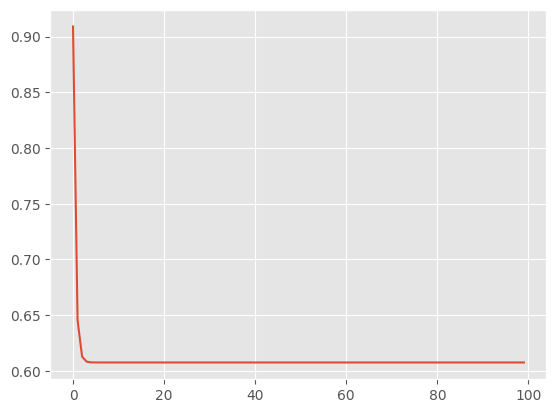

In [8]:
plt.plot(kalman_var)

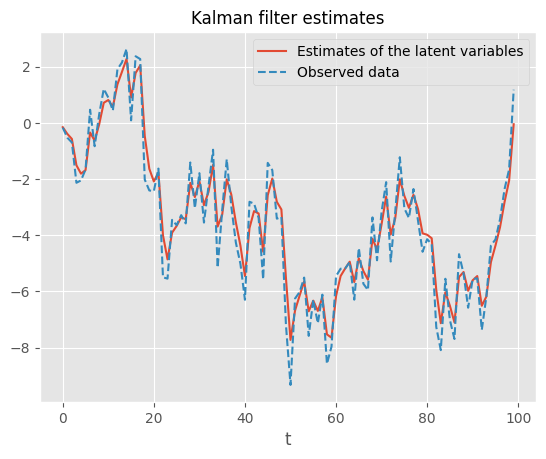

In [9]:
# Plotting the obtained estimates
plt.plot(X_hat, label='Estimates of the latent variables')
plt.plot(Y, ls='--',label='Observed data')
plt.xlabel("t")
plt.title("Kalman filter estimates",size=12)
plt.legend()

Text(0, 0.5, '$\\hat{p} (y_{1:t})$')

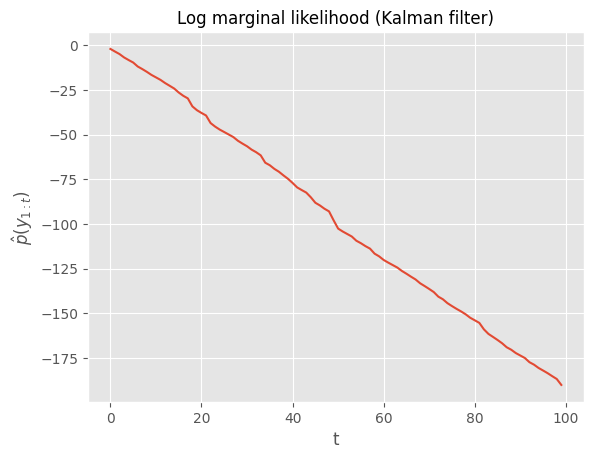

In [10]:
# Plotting estimates for log marginal likelihood
plt.plot(kalman_lik, label='kalman')
plt.title("Log marginal likelihood (Kalman filter)",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
# plt.legend()

## Sequential Monte Carlos approaches

All of the approaches considered are versions of Sequential Monte Carlo. As they are being applied to the same model and dataset, the prior and likelihood distributions are the same. The only difference studied in this work is the choice of proposal distribution. Therefore, we define belllow the prior and likelihood distributions to be used.

In [11]:
def likelihood(x_t):
    '''
    Defines g( y_t | x_t ).
    
    Returns:
        The torch.distribution of y_t given x_t. The 
        returned object allows sampling and evaluating
        the log pdf at a given point.
    ---
    >> x_t: (torch.tensor)
    '''
    return Normal(x_t, 1)
    
def prior(x_prev):
    '''
    Defines f(x_0) and f(x_t | x_{t-1}).

    Returns: 
        The torch.distribution of x_0 or of x_t given x_{t-1}.
        The returned object allows sampling and evaluating
        the log pdf at a given point.
    ---
    >> x_prev: (torch.tensor or None)
    '''
    if x_prev is None:
        # Initial distribution of process X_t
        return Normal(0,1)
    else:
        # Transition distribution of process X_t
        return Normal(0.95*x_prev, 1)

Also, we can already define some functions useful for evaluating each approach, such as effective sample size, log marginal likelihood estimates, and mean and variance of estimates.

In [12]:
def ESS(log_w): 
    '''
    Calculates the effective sample size.

    Returns:
        A torch.tensor with the effective sample size
        at each time step.
    ---
    >> log_w: the log weights of SMC through time steps (torch.tensor)
    '''
    log_w_norm = log_w - torch.logsumexp(log_w, dim=1, keepdim=True)
    w = torch.exp(log_w_norm)
    ess = 1.0 / torch.sum(w**2, dim=1)
    return ess


def log_marginal_likelihood(log_w):
    '''
    Returns the estimated log marginal likelihood of the data.

    ---
    >> log_w: the log weights of SMC through time steps (torch.tensor)
    '''
    T, N = log_w.shape
    marginal_likelihood = torch.zeros(T)
    for t in range(T):
        # Calculates the log marginal for 1, ..., t
        cur_logsumexp =  torch.logsumexp(log_w[:t+1, :], dim=1, keepdim=True)
        shape = cur_logsumexp.shape
        cur_marginal = torch.sum(cur_logsumexp - np.log(N) * torch.ones(shape))
        marginal_likelihood[t] = cur_marginal
    return marginal_likelihood

### SMC with prior as proposal

The first approach we will consider for comparison is the classical SMC with the prior distribution as the proposal.

In [13]:
def SMC_prior(y_seq, N, T, latent_dim=1):
    '''
    Apply SMC algorithm using the prior distribution
    as the proposal.

    Returns:
        log_w: obtained log weights (torch.tensor)
        x_particles: all particles generated (torch.tensor)
        ancestors: ancestors sampled through SMC (torch.tensor)
        x_estimates: final estimates for the latent data (torch.tensor)
    ---
    >> y_seq: observed data (list of torch.tensor)
    >> N: number of particles (int)
    >> T: number of time steps (int)
    >> latent_dim: dimension of the observed data (int)
    '''
    # Initialize
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    # Step 1
    x_t = prior(None).sample((N,latent_dim))
    x_particles[0] = x_t
    log_w[0] = likelihood(x_t).log_prob(y_seq[0]).squeeze()

    # Steps from 2 to T
    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        x_t = prior(x_prev).sample()
        x_particles[t] = x_t

        log_w[t] = likelihood(x_t).log_prob(y_seq[t]).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, b_T]
        if t > 0:
            b_T = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_estimates


In [14]:
N = 1000
T = 100
log_w_prior, x_part_prior, a_prior, x_prior = SMC_prior(y_seq, N, T)

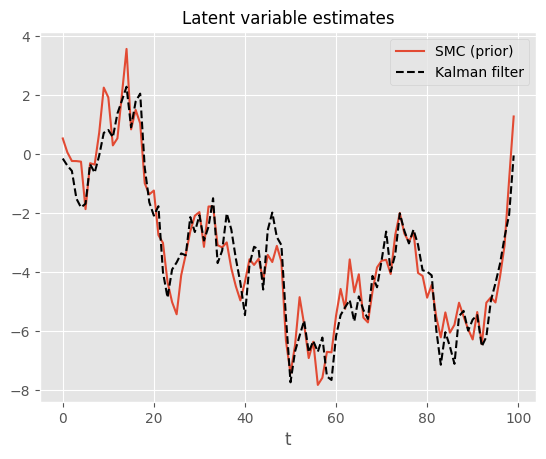

In [15]:
# Plotting estimates
plt.plot(x_prior.numpy(), label='SMC (prior)')
plt.plot(X_hat, label='Kalman filter', c='black',ls='--')
plt.xlabel('t')
plt.title('Latent variable estimates',size=12)
plt.legend()

(0.0, 1000.0)

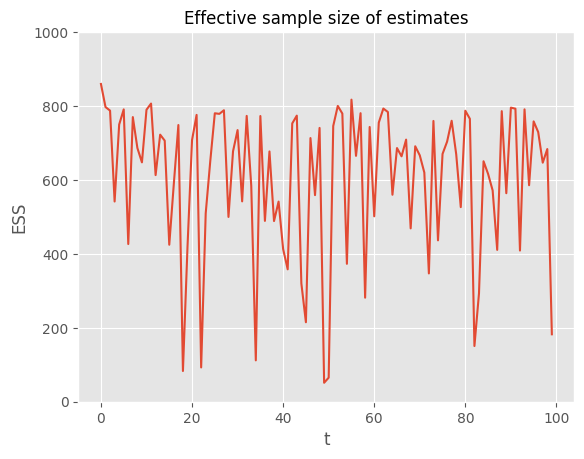

In [16]:
# Plotting ESS
ESS_prior = ESS(log_w_prior)
plt.plot(ESS_prior)
plt.title('Effective sample size of estimates',size=12)
plt.xlabel('t')
plt.ylabel('ESS')
plt.ylim((0,1000))

In [17]:
prior_lik = log_marginal_likelihood(log_w_prior)

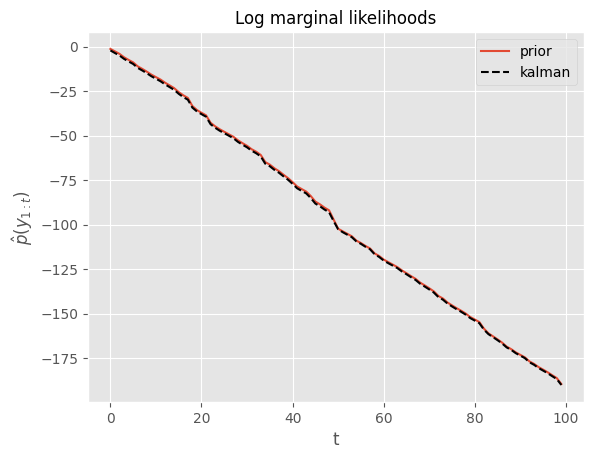

In [18]:
plt.plot(prior_lik, label='prior')
plt.plot(kalman_lik, label='kalman',ls='--',c='black')
plt.title("Log marginal likelihoods",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
plt.legend()

Text(0.5, 0, 't')

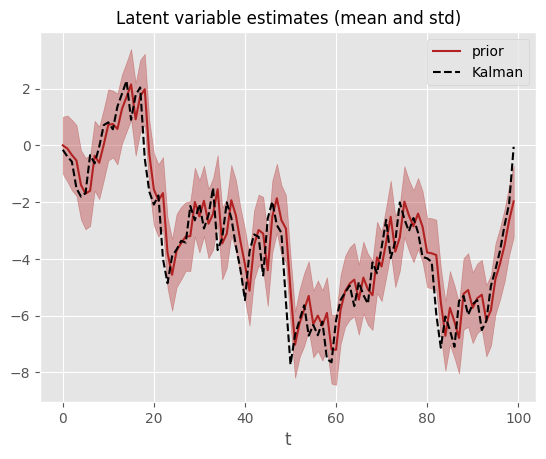

In [19]:
mu = x_part_prior.detach().mean(axis=1)
s = x_part_prior.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='prior',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick')
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.legend()
plt.title("Latent variable estimates (mean and std)",size=12)
plt.xlabel('t')

## SMC with optimal proposal 

In [20]:
def optimal_proposal(x_prev, y_t, A=.95, C=1, Q=1, R=1):
    if x_prev is None:
        x_prev = 0.0
    var_inv = 1/Q + (C ** 2)/R
    sigma2 = 1/var_inv
    mu = sigma2 * (A * x_prev/Q + C * y_t/R)
    return Normal(mu, math.sqrt(sigma2))


def SMC_opt(y_seq, N, T, latent_dim = 1):
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    x_t = optimal_proposal(None, y_seq[0]).sample((N,))
    x_particles[0] = x_t
    log_w[0] = (
        prior(None).log_prob(x_t) +
        likelihood(x_t).log_prob(y_seq[0]) -
        optimal_proposal(None, y_seq[0]).log_prob(x_t)
    ).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        x_t = optimal_proposal(x_prev, y_seq[t]).sample()
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_prev).log_prob(x_t) +
            likelihood(x_t).log_prob(y_seq[t]) -
            optimal_proposal(x_prev, y_seq[t]).log_prob(x_t)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, b_T]
        if t > 0:
            b_T = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_estimates


In [22]:
N = 1000
T = 100
log_w_opt, x_part_opt, a_opt, x_opt = SMC_opt(y_seq, N, T)

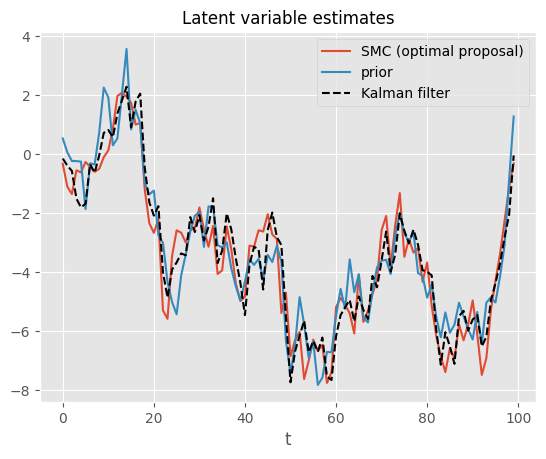

In [23]:
# Plotting estimates
plt.plot(x_opt.numpy(),label='SMC (optimal proposal)')
plt.plot(x_prior.numpy(),label='prior')
plt.plot(X_hat,label='Kalman filter',c='black',ls='--')
plt.xlabel('t')
plt.title('Latent variable estimates',size=12)
plt.legend()

(0.0, 1000.0)

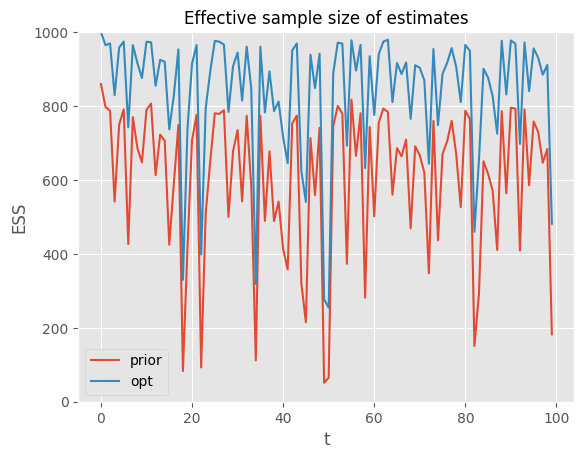

In [24]:
# Plotting ESS
ESS_opt = ESS(log_w_opt)
plt.plot(ESS_prior,label='prior')
plt.plot(ESS_opt, label='opt')
plt.legend()
plt.title('Effective sample size of estimates',size=12)
plt.xlabel('t')
plt.ylabel('ESS')
plt.ylim((0,1000))

In [25]:
opt_lik = log_marginal_likelihood(log_w_opt)

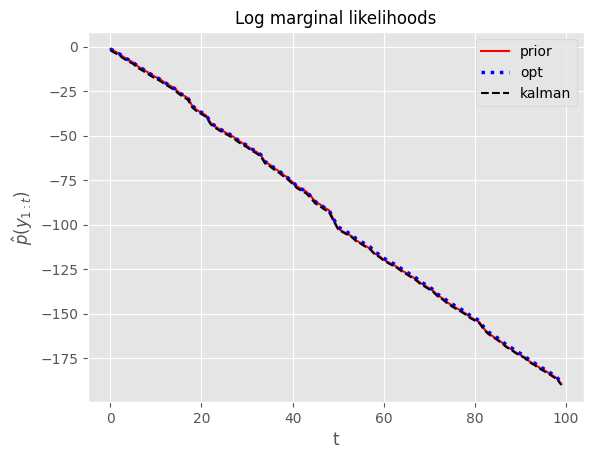

In [26]:
plt.plot(prior_lik, label='prior',c='red')
plt.plot(opt_lik, label='opt',ls='dotted',c='blue',lw=2.5)
plt.plot(kalman_lik, label='kalman',ls='--',c='black')
plt.title("Log marginal likelihoods",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
plt.legend()

Text(0.5, 1.0, 'Latent variable estimates')

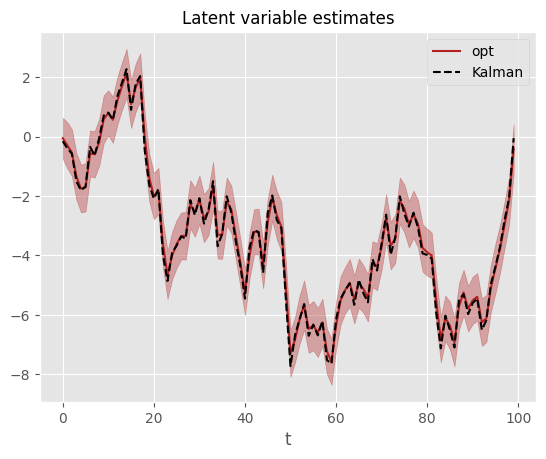

In [27]:
mu = x_part_opt.detach().mean(axis=1)
s = x_part_opt.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='opt',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick')
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.legend()
plt.xlabel("t")
plt.title("Latent variable estimates",size=12)

## Variational SMC

In [28]:
# Functions to be used
def prior_VSMC(x, x_prev):
    return prior(x_prev).log_prob(x)

def likelihood_VSMC(y_t, x_t):
    return likelihood(x_t).log_prob(y_t)

def proposal_logpdf(x, x_prev, lambda_):
    if x_prev is None:
        return Normal(lambda_, 1).log_prob(x)
    else:
        return Normal(lambda_ * x_prev, 1).log_prob(x)

def proposal(x_prev, eps, lambda_):
    if x_prev is None:
        mu = lambda_
    else:
        mu = lambda_ * x_prev
    return eps + mu



In [29]:
# VSMC
def run_vsmc(y_seq, lambda_, N, T):
    latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, lambda_)
    x_particles[0] = x_t
    log_w[0] = (
        prior_VSMC(x_t, None) + likelihood_VSMC(y_seq[0], x_t) - proposal_logpdf(x_t, None, lambda_)
    ).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        # print(w_prev)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, lambda_)
        x_particles[t] = x_t

        log_w[t] = (
            prior_VSMC(x_t, x_prev) + likelihood_VSMC(y_seq[t], x_t) - proposal_logpdf(x_t, x_prev, lambda_)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    i = b_T
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, i]
        if t > 0:
            i = ancestors[t, i]
    
    return log_w, x_particles, ancestors, x_estimates


def surrogate_elbo(log_w):
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
    return logZ.sum()

def train_vsmc(y_seq, T, N, n_steps=100, lr=1e-3):
    # Parameter to learn
    lambda_ = torch.nn.Parameter(torch.randn((1,)))
    optimizer = torch.optim.Adam([lambda_], lr=lr)
    history = []
    
    # Training loop
    for step in range(n_steps):
        optimizer.zero_grad()
        log_w,_,_,_ = run_vsmc(y_seq, lambda_, N, T=T)
        elbo = surrogate_elbo(log_w)
        loss = -elbo
        loss.backward()
        if step % 50 == 0:
            print(f"Step {step:03d} | ELBO: {elbo.item():.2f} | grad: {lambda_.grad.item():.4f}")
        optimizer.step()
        history.append(loss)
    print(f"Training finished!\nFinal loss: {loss.item()}")
    return history, lambda_


In [30]:
n_steps = 500
T=100
N = 1000
y_seq = [torch.tensor([i]) for i in Y]
history, lambda_ = train_vsmc(y_seq, T, N, n_steps,lr=0.01)

Step 000 | ELBO: -399.23 | grad: -390.8197
Step 050 | ELBO: -220.53 | grad: -355.9267
Step 100 | ELBO: -190.22 | grad: -120.8822
Step 150 | ELBO: -189.52 | grad: 2103.6831
Step 200 | ELBO: -189.03 | grad: -102.2663
Step 250 | ELBO: -189.55 | grad: 601.1177
Step 300 | ELBO: -189.37 | grad: -994.2873
Step 350 | ELBO: -189.24 | grad: -105.0819
Step 400 | ELBO: -189.52 | grad: 181.0736
Step 450 | ELBO: -188.26 | grad: 461.9479
Training finished!
Final loss: 189.18649291992188


Text(0, 0.5, '-ELBO')

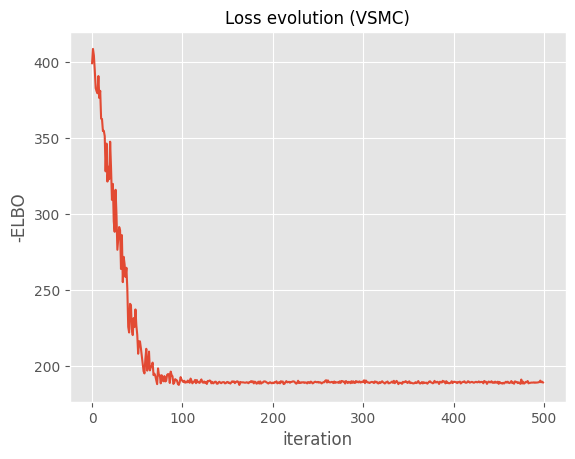

In [31]:
plt.plot([i.detach() for i in history])
plt.title("Loss evolution (VSMC)",size=12)
plt.xlabel("iteration")
plt.ylabel("-ELBO")

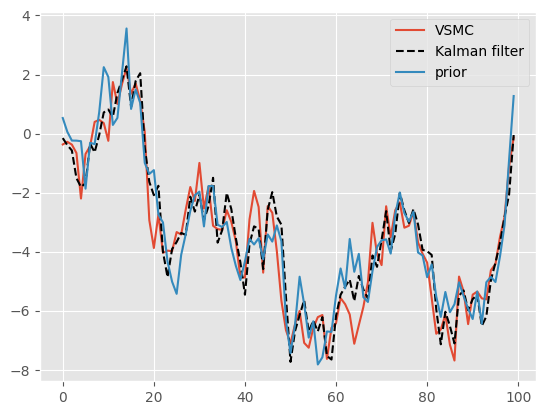

In [32]:
log_w_vsmc, x_part_vsmc, a_vsmc, x_vsmc = run_vsmc(y_seq, lambda_, N, 100)

plt.plot(x_vsmc.detach().numpy(),label='VSMC')
plt.plot(X_hat,label='Kalman filter',c='black',ls='--')
plt.plot(x_prior.numpy(), label="prior")
plt.legend()

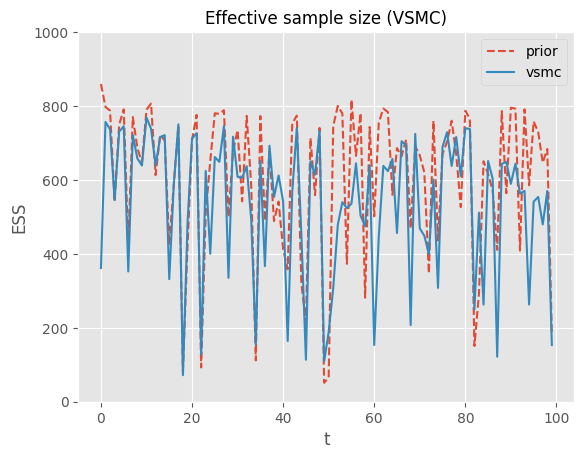

In [33]:
# Comparing ESS
plt.plot(ESS(log_w_prior),label='prior',ls='--')
plt.plot(ESS(log_w_vsmc).detach().numpy(),label='vsmc')
plt.ylim((0,N))
plt.xlabel("t")
plt.ylabel("ESS")
plt.title("Effective sample size (VSMC)",size=12)
plt.legend()

In [34]:
vsmc_lik = log_marginal_likelihood(log_w_vsmc)

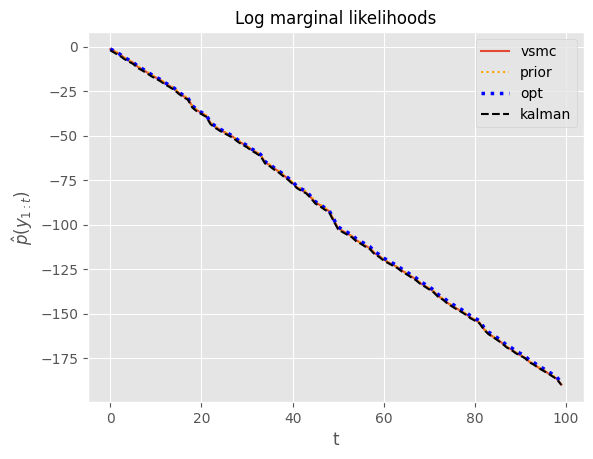

In [35]:
plt.plot(vsmc_lik.detach().numpy(), label='vsmc')
plt.plot(prior_lik, label='prior',c='orange',ls='dotted')
plt.plot(opt_lik, label='opt',ls='dotted',c='blue',lw=2.5)
plt.plot(kalman_lik, label='kalman',ls='--',c='black')
plt.title("Log marginal likelihoods",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
plt.legend()

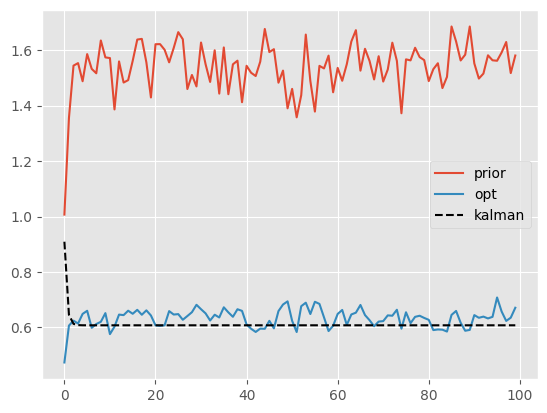

In [36]:
plt.plot(x_part_prior.std(axis=1)**2,label='prior')
plt.plot(x_part_opt.std(axis=1)**2,label='opt')
plt.plot(kalman_var, label='kalman', c='black',ls='--')
plt.legend()

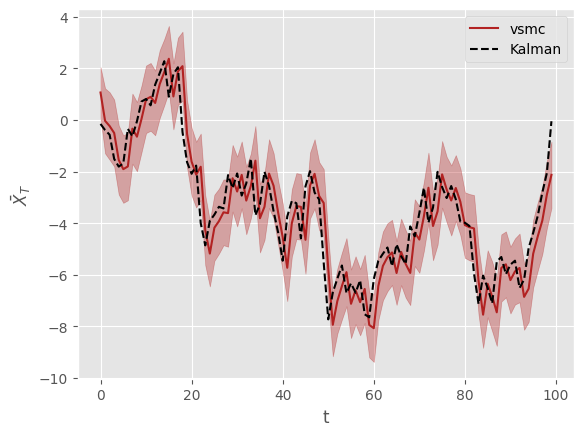

In [37]:
mu = x_part_vsmc.detach().mean(axis=1)
s = x_part_vsmc.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='vsmc',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick')
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.xlabel('t')
plt.ylabel(r"$\bar{X}_T$")
plt.legend()

---

## Variational SMC (unstable version)


In [1]:
class LinearProposal(nn.Module):
    def __init__(self, a, b=torch.tensor([0.0]), c=torch.tensor([0.0]), log_sigma=torch.tensor([1.0])):
        super().__init__()
        self.a = a #nn.Parameter(torch.tensor([0.5]))
        self.b = b #nn.Parameter(torch.tensor([0.5]))
        self.c = c #nn.Parameter(torch.tensor([0.0]))
        self.log_sigma = log_sigma #nn.Parameter(torch.tensor([0.0]))

    def forward(self, x_prev, y_t, eps):
        mu = self.a * x_prev + self.b * y_t + self.c
        std = torch.exp(self.log_sigma)
        return mu + std * eps

    def log_prob(self, x, x_prev, y_t):
        mu = self.a * x_prev + self.b * y_t + self.c
        std = torch.exp(self.log_sigma)
        return Normal(mu, std).log_prob(x)



def surrogate_elbo(log_w):
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
    return logZ.sum()
    

NameError: name 'nn' is not defined

In [ ]:
# VSMC
def VSMC(y_seq, N, T, proposal, latent_dim = 1):
    # latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    # Reparametrization trick
    eps = torch.randn(N, latent_dim)
    x_t = proposal.forward(torch.tensor([0.0]), y_seq[0], eps)#, proposal_id)
    
    x_particles[0] = x_t
    log_w[0] = (
        prior(None).log_prob(x_t) 
        + likelihood(x_t).log_prob(y_seq[0])
        - proposal.log_prob(x_t, torch.tensor([0.0]), y_seq[0])#, proposal_id)
    ).squeeze()

    for t in range(1, T):
        
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal.forward(x_prev, y_seq[t], eps)# lambda_)#, proposal_id)
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_prev).log_prob(x_t) 
            + likelihood(x_t).log_prob(y_seq[t]) 
            - proposal.log_prob(x_t, x_prev, y_seq[t])#, proposal_id)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    i = b_T
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, i]
        if t > 0:
            i = ancestors[t, i]

    return log_w, x_particles, ancestors, x_estimates


In [ ]:
def train_vsmc(y_seq, T, N, n_steps=100, lr=1e-3):

    a = nn.Parameter(torch.randn((1,)))
    b = nn.Parameter(torch.tensor([0.0]))
    c = nn.Parameter(torch.tensor([0.0]))
    log_sigma = nn.Parameter(torch.tensor([0.0]))
    
    # b = torch.tensor([0.0])
    # c = torch.tensor([0.0])
    # log_sigma = torch.tensor([1.0])
    
    proposal = LinearProposal(a, b, c, log_sigma)
    
    optimizer = torch.optim.Adam(proposal.parameters(), lr=lr)
    history = []
    
    # Training loop
    for step in range(n_steps):
        optimizer.zero_grad()
        log_w,_,_,_ = VSMC(y_seq, N, T, proposal)#, proposal_id)
        elbo = surrogate_elbo(log_w)
        loss = -elbo
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            with torch.no_grad():
                print(f"Step {step:03d} | ELBO: {elbo.item():.2f}")# | grad: {proposal.paramaters().grad.item():.4f}")
                # print(proposal.a, proposal.b, proposal.log_sigma)
            # print(lambda_,'\n')
        history.append(loss.item())
    print(f"Training finished!\nFinal loss: {loss.item()}")
    return history, proposal

In [ ]:
small_y = y_seq[:5]

In [ ]:
n_steps = 150
T = 100
N = 1000
history, proposal = train_vsmc(y_seq, T, N, n_steps,lr=0.1)

Step 000 | ELBO: -577.13
Step 010 | ELBO: -189.13
Step 020 | ELBO: -194.11
Step 030 | ELBO: -189.33
Step 040 | ELBO: -202.96
Step 050 | ELBO: -193.40
Step 060 | ELBO: -198.14
Step 070 | ELBO: -191.89
Step 080 | ELBO: -200.02
Step 090 | ELBO: -188.02
Step 100 | ELBO: -200.82
Step 110 | ELBO: -193.46
Step 120 | ELBO: -189.50
Step 130 | ELBO: -188.89
Step 140 | ELBO: -194.20
Training finished!
Final loss: 195.07272338867188


Text(0.5, 1.0, 'Loss history')

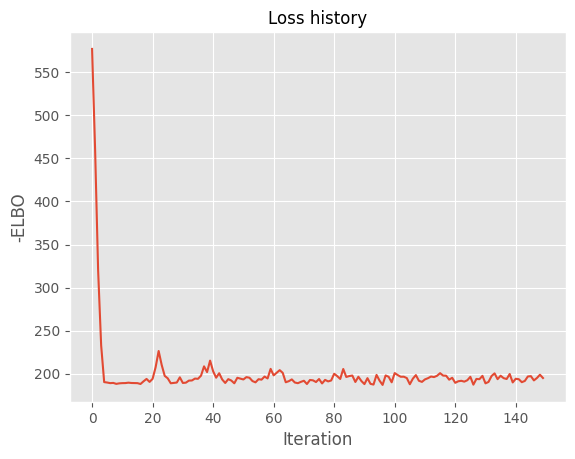

In [ ]:
plt.plot(history)
plt.ylabel("-ELBO")
plt.xlabel("Iteration")
plt.title("Loss history",size=12)

In [ ]:
N = 1000
T = 100
log_w_vsmc_lin, x_part_vsmc_lin, a_vsmc_lin, x_vsmc_lin = VSMC(y_seq, N, T, proposal)

In [ ]:
small_y = y_seq[:]

100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.30it/s]


Text(0.5, 1.0, 'ELBO landscape')

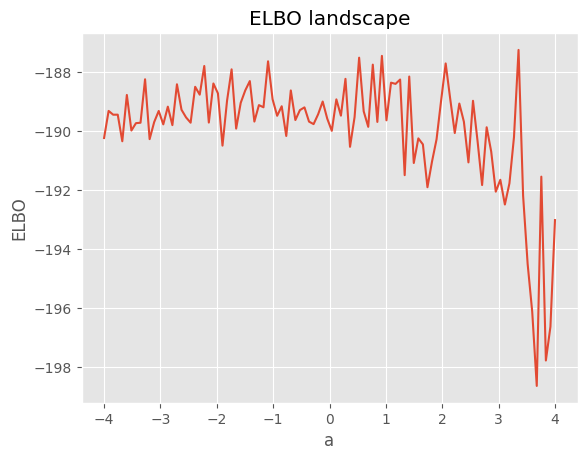

In [ ]:
lambdas = torch.linspace(-4, 4, 100)
elbos = []

for val in tqdm(lambdas):
    lambda_test = torch.tensor([val])
    proposal_test = LinearProposal(
        a=torch.tensor([0.5]),
        c=lambda_test
    )
    log_w, _, _, _ = VSMC(small_y, 1000, 100, proposal_test)
    elbos.append(surrogate_elbo(log_w).item())

plt.plot(lambdas.numpy(), elbos)
plt.xlabel("a")
plt.ylabel("ELBO")
plt.title("ELBO landscape")

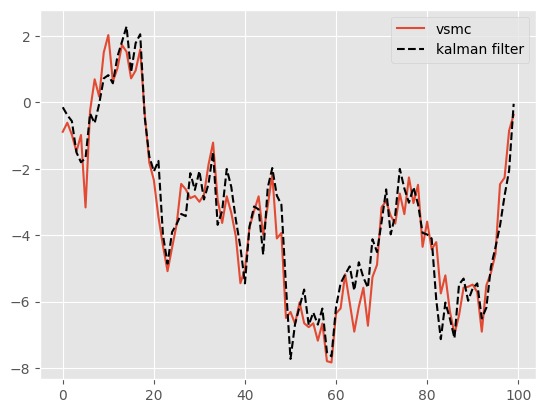

In [ ]:
plt.plot(x_vsmc_lin.detach().numpy(),label='vsmc')
plt.plot(X_hat,label='kalman filter',c='black',ls='--')
# plt.plot(x_prior.numpy(), label="SMC with prior")
# plt.plot(x_opt.numpy(), label="SMC optimal")
plt.legend()

In [ ]:
ESS(log_w_vsmc_lin)

tensor([ 9.7774,  5.7251,  5.3300,  6.2696,  7.6664,  7.2326,  7.2706,  2.8260,
         5.9709,  5.9247,  4.7260,  8.6482, 12.0691, 14.1296,  8.2046,  7.1501,
         7.1469, 12.2116,  6.1553,  5.6791,  6.4824,  9.3516,  2.8566, 14.9070,
        10.5895,  4.4866,  4.7436,  7.4094,  7.7664,  6.0324,  8.4783,  3.7119,
         9.8439,  5.0633,  2.8257,  5.0657,  7.3567,  9.5962, 13.7139, 10.1489,
         3.9939, 15.7878, 12.4455,  5.9537,  8.2980, 15.5980, 10.0434,  7.7844,
        17.7809,  8.8074,  1.6212,  9.5553,  8.7167,  6.6855,  7.7779,  9.8742,
        14.8226, 13.4475,  4.9636, 11.7799,  9.3691,  9.6467,  8.9150, 13.9931,
         7.0937,  5.4382, 11.2618,  3.7947, 13.8896,  7.4114,  7.7804, 11.3282,
         6.1402,  6.9901,  7.4305,  5.7784,  5.3437,  9.7038,  3.8052,  3.0784,
         4.4200, 13.4628,  4.0288,  2.7079,  6.8248,  8.5875, 15.7114,  7.4457,
         5.6403,  6.7679, 17.5378, 19.1205,  5.9019, 11.6683, 14.1467,  8.4274,
         6.2776, 10.7813,  6.2370,  6.89

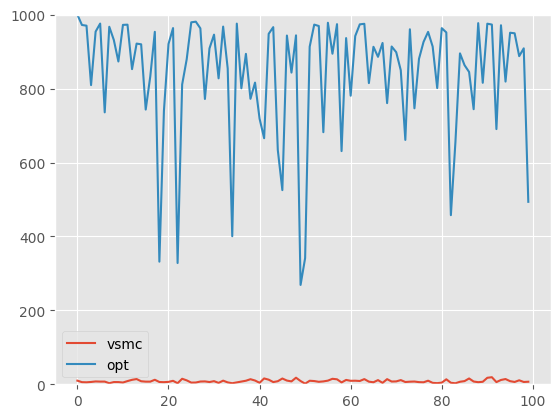

In [ ]:
plt.plot(ESS(log_w_vsmc_lin).detach().numpy(),label='vsmc')
# plt.plot(ESS(log_w_prior),label='prior')
plt.plot(ESS(log_w_opt),label='opt')
plt.ylim((0,N))
plt.legend()

In [ ]:
n_steps = 150
T = 100
N = 1000
history, lambda_2 = train_vsmc(y_seq, T, N, 1, n_steps,lr=0.01)

Parameter containing:
tensor([0.9500], requires_grad=True) 

Step 000 | ELBO: -189.26 | grad: -427.6988
Parameter containing:
tensor([0.9500], requires_grad=True) 

Step 010 | ELBO: -190.05 | grad: 1176.6512
Parameter containing:
tensor([1.0511], requires_grad=True) 

Step 020 | ELBO: -188.51 | grad: -832.2629
Parameter containing:
tensor([1.0332], requires_grad=True) 

Step 030 | ELBO: -189.48 | grad: 725.5983
Parameter containing:
tensor([1.0525], requires_grad=True) 

Step 040 | ELBO: -188.80 | grad: -60.6811
Parameter containing:
tensor([1.0453], requires_grad=True) 

Step 050 | ELBO: -189.25 | grad: -356.6816
Parameter containing:
tensor([1.0449], requires_grad=True) 

Step 060 | ELBO: -189.06 | grad: 341.4381
Parameter containing:
tensor([1.0429], requires_grad=True) 

Step 070 | ELBO: -189.65 | grad: 340.7644
Parameter containing:
tensor([1.0471], requires_grad=True) 

Step 080 | ELBO: -189.05 | grad: 887.3358
Parameter containing:
tensor([1.0473], requires_grad=True) 

Step 090

Text(0.5, 1.0, 'Loss history')

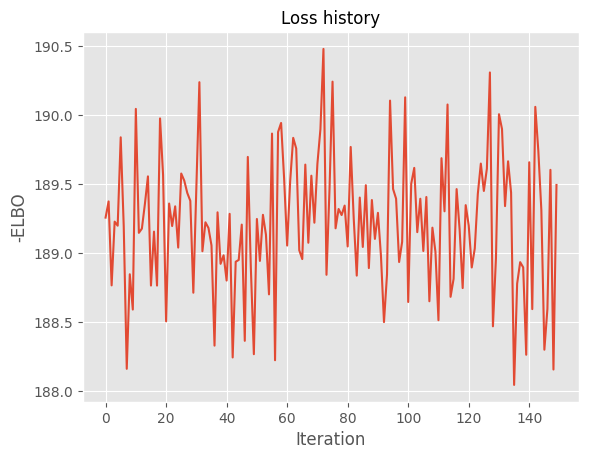

In [ ]:
plt.plot([i.detach() for i in history])
plt.ylabel("-ELBO")
plt.xlabel("Iteration")
plt.title("Loss history",size=12)

In [ ]:
log_w_vsmc_2, x_part_vsmc_2, a_vsmc_2, x_vsmc_2 = VSMC(y_seq, lambda_2, N, T, proposal_id=1)

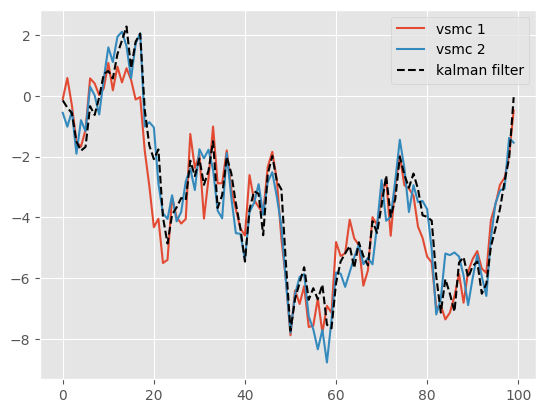

In [ ]:
plt.plot(x_vsmc_1.detach().numpy(),label='vsmc 1')
plt.plot(x_vsmc_2.detach().numpy(),label='vsmc 2')
plt.plot(X_hat,label='kalman filter',c='black',ls='--')
# plt.plot(x_prior.numpy(), label="SMC with prior")
# plt.plot(x_opt.numpy(), label="SMC optimal")
plt.legend()

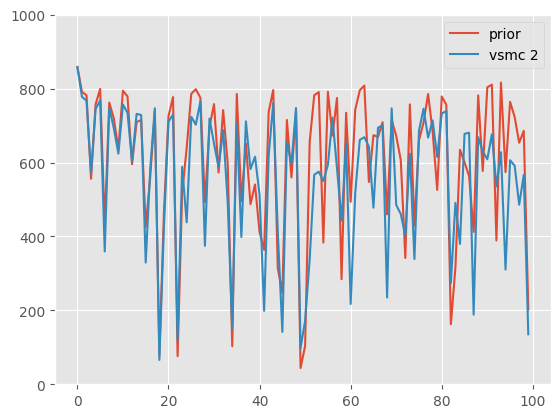

In [ ]:
plt.plot(ESS(log_w_prior).numpy(),label='prior')
# plt.plot(ESS(log_w_vsmc_1).detach().numpy(),label='vsmc 1')
plt.plot(ESS(log_w_vsmc_2).detach().numpy(),label='vsmc 2')
# plt.plot(ESS(log_w_prior),label='prior')
# plt.plot(ESS(log_w_opt),label='opt')
plt.ylim((0,N))
plt.legend()

## Normalizing Flow-based VSMC

Finally, we implement a normalizing flow for choosing a proposal for VSMC.

In [38]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, context_dim=None):
        super().__init__()
        total_in = in_dim + (context_dim if context_dim is not None else 0)
        self.net = nn.Sequential(
            nn.Linear(total_in, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, in_dim)
        )

    def forward(self, x, context=None):
        if context is not None:
            x = torch.cat([x, context], dim=-1)
        return self.net(x)

class RealNVPLayer(nn.Module):
    def __init__(self, dim, mask, context_dim=None):
        super().__init__()
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.scale_net = MLP(dim, context_dim=context_dim)
        self.translate_net = MLP(dim, context_dim=context_dim)

    def forward(self, x, context=None):
        x_masked = x * self.mask
        # Trying to regularize network outputs
        s_ = torch.tanh(self.scale_net(x_masked, context)) * 2.0
        s = s_ * (1 - self.mask)

        t_ = torch.tanh(self.translate_net(x_masked, context)) * 2.0
        t = t_ * (1 - self.mask)

        # s = self.scale_net(x_masked, context) * (1 - self.mask)
        # t = self.translate_net(x_masked, context) * (1 - self.mask)
        return x_masked + (1 - self.mask) * (x * torch.exp(s) + t)

    def inverse(self, y, context=None):
        y_masked = y * self.mask
        # Trying to regularize network outputs
        s_ = torch.tanh(self.scale_net(y_masked, context)) * 2.0
        s = s_ * (1 - self.mask)
        t = self.translate_net(y_masked, context) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det_J = torch.sum(s, dim=1)
        return x, log_det_J

class RealNVP(nn.Module):
    def __init__(self, dim, n_layers, base_dist, context_dim=None):
        super().__init__()
        self.dim = dim
        self.base_dist = base_dist
        self.layers = nn.ModuleList([
            RealNVPLayer(dim, mask=torch.tensor([i % 2, (i + 1) % 2], dtype=torch.float32), context_dim=context_dim)
            for i in range(n_layers)
        ])

    def forward(self, z, context=None):
        for i, layer in enumerate(self.layers):
            z = layer(z, context)
            if torch.isnan(z).any() or torch.isinf(z).any():
                print(f"Flow z has NaN/Inf after layer {i}")
        return z

    def inverse(self, x, context=None):
        log_det = torch.zeros(x.size(0), device=x.device)
        for layer in reversed(self.layers):
            x, log_j = layer.inverse(x, context)
            log_det -= log_j

        if torch.isnan(x).any() or torch.isinf(x).any():
            print("Flow z has NaN/Inf")

        if torch.isnan(log_det).any() or torch.isinf(log_det).any():
            print("Flow log_det has NaN/Inf")

        return x, log_det

    def log_prob(self, x, context=None):
        
        z, log_det = self.inverse(x, context)

        # z_check, log_det = flow.inverse(x_t, context=x_prev)

        if torch.isnan(z).any() or torch.isinf(z).any():
            print("Flow z has NaN/Inf")

        if torch.isnan(log_det).any() or torch.isinf(log_det).any():
            print("Flow log_det has NaN/Inf")

        clamped_z = torch.clamp(z, min=-1e6, max=1e6)
        # print(
        # ed_z)

        base_log_prob = self.base_dist.log_prob(clamped_z)

        return base_log_prob + log_det
        # return self.base_dist.log_prob(z) + log_det

    def sample(self, n_samples, context=None):
        z = self.base_dist.sample((n_samples, self.dim)).to(next(self.parameters()).device)
        return self.forward(z, context)

def proposal(x_prev, eps, flow):
    return flow.forward(eps, context=x_prev)

def proposal_logpdf(x_t, x_prev, flow):
    return flow.log_prob(x_t, context=x_prev)


In [39]:
from torch.distributions import MultivariateNormal

latent_dim = 2  # for example
context_dim = latent_dim
base_dist = MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))

flow = RealNVP(dim=latent_dim, n_layers=4, base_dist=base_dist, context_dim=context_dim)


Training the thing

In [40]:
def vsmc_nf(y_seq, N, T, flow):
    latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N, device=y_seq[0].device)
    x_particles = torch.zeros(T, N, latent_dim, device=y_seq[0].device)
    ancestors = torch.zeros(T, N, dtype=torch.long, device=y_seq[0].device)

    eps = torch.randn(N, latent_dim, device=y_seq[0].device)
    x_t = proposal(None, eps, flow)
    x_particles[0] = x_t
    log_w[0] = (
        prior(x_t, None) + likelihood(y_seq[0], x_t) - proposal_logpdf(x_t, None, flow)
    ).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim, device=y_seq[0].device)
        x_t = proposal(x_prev, eps, flow)
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_t, x_prev) + likelihood(y_seq[t], x_t) - proposal_logpdf(x_t, x_prev, flow)
        ).squeeze()

    # Estimate log marginal likelihood (logZ)
    # logZ = torch.logsumexp(log_w[-1], dim=0) - torch.log(torch.tensor(N, device=log_w.device, dtype=torch.float))
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(N, device=log_w.device, dtype=torch.float32))
    return logZ, log_w, x_particles, ancestors



In [41]:
a = torch.sum(torch.logsumexp(log_w_prior, dim=1) - np.log(N) * torch.ones(100))
b = torch.logsumexp(log_w_prior[-1], dim=0) - torch.log(torch.tensor(N, dtype=torch.float32))
a, b

(tensor(-189.4975), tensor(-3.3452))

In [42]:
# === Prior and Likelihood ===
def prior(x_t, x_prev):
    return MultivariateNormal(torch.zeros_like(x_t), torch.eye(latent_dim)).log_prob(x_t)

def likelihood(y_t, x_t):
    return MultivariateNormal(x_t, 0.1 * torch.eye(latent_dim)).log_prob(y_t)

# === Proposal Wrappers ===
def proposal(x_prev, eps, flow):
    if x_prev is None:
        x_prev = torch.zeros_like(eps)
    return flow.forward(eps, context=x_prev)

# # Loss
# def surrogate_elbo(log_w):
#     logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
#     return logZ.sum()

In [60]:
# torch.cat((y_seq[0], torch.tensor([0.0])))


In [43]:
latent_dim = 2
N = 1000
T = 100
y_seq_test = torch.cumsum(torch.randn(T, latent_dim) * 0.5, dim=0)
y_seq_test = y_seq_test + 0.1 * torch.randn_like(y_seq_test)
y_seq_test.shape

torch.Size([100, 2])

In [44]:
import torch
from torch.distributions import MultivariateNormal

# # === Dummy Data ===
# latent_dim = 2
# N = 1000
# T = 100
# y_seq = torch.cumsum(torch.randn(T, latent_dim) * 0.5, dim=0)
# y_seq = y_seq + 0.1 * torch.randn_like(y_seq)



def proposal_logpdf(x_t, x_prev, flow):
    if x_prev is None:
        x_prev = torch.zeros_like(x_t)
    return flow.log_prob(x_t, context=x_prev)

# === VSMC with ELBO ===
def vsmc_nf(y_seq, N, T, flow):
    latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, flow)
    x_particles[0] = x_t
    log_w[0] = prior(x_t, None) + likelihood(y_seq[0], x_t) - proposal_logpdf(x_t, None, flow)

    for t in range(1, T):
        log_w_prev = log_w[t - 1]
        log_w_prev = log_w_prev - torch.max(log_w_prev)  # stabilize softmax
        w_prev = torch.softmax(log_w_prev, dim=0)
        w_prev = torch.clamp(w_prev, min=1e-8)
        w_prev = w_prev / w_prev.sum()

        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, flow)
        x_particles[t] = x_t

        log_w[t] = prior(x_t, x_prev) + likelihood(y_seq[t], x_t) - proposal_logpdf(x_t, x_prev, flow)

    # logZ = torch.logsumexp(log_w[-1], dim=0) - torch.log(torch.tensor(N, dtype=torch.float))
    # logZ = torch.logsumexp(log_w, dim=1) - np.log(N) * torch.ones(T)

    # Must be negative:
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.shape[1], dtype=torch.float32))
    # return logZ_t.sum()
    elbo = torch.clamp(logZ, max = 0).sum()
    return elbo, log_w, x_particles, ancestors


In [123]:
# test = torch.logsumexp(log_w_prior, dim=1) - torch.log(torch.tensor(log_w_prior.shape[1], dtype=torch.float32))
# test[1] = 1.2# test.sum()
# test
# torch.clamp(test, max=0)

In [124]:
# log_w_prior.shape[1]

The data must be at least 2 dimensional in order for the RealNVP to make sense. Thus, we will add a new dimension to data by two different approaches and compare them. First, we assign zeros to every entry in the new dimension; second, we repeat the data in the new dimension.

In [45]:
# Assign zeros to new dimension
y_seq_zeros = torch.stack([torch.cat((i, torch.tensor([0]))) for i in y_seq])
print(y_seq_zeros[:10],'\n')  # printing the first 10 values

# Repeat data in new dimension
y_seq_repeat = torch.stack([torch.cat((i, i)) for i in y_seq])
print(y_seq_repeat[:10],'\n')  # printing the first 10 values

tensor([[-0.1666,  0.0000],
        [-0.5247,  0.0000],
        [-0.6954,  0.0000],
        [-2.1302,  0.0000],
        [-2.0467,  0.0000],
        [-1.6577,  0.0000],
        [ 0.4692,  0.0000],
        [-0.8291,  0.0000],
        [ 0.3087,  0.0000],
        [ 1.2102,  0.0000]]) 

tensor([[-0.1666, -0.1666],
        [-0.5247, -0.5247],
        [-0.6954, -0.6954],
        [-2.1302, -2.1302],
        [-2.0467, -2.0467],
        [-1.6577, -1.6577],
        [ 0.4692,  0.4692],
        [-0.8291, -0.8291],
        [ 0.3087,  0.3087],
        [ 1.2102,  1.2102]]) 



In [46]:
MultivariateNormal(torch.zeros((2,)), torch.eye(2)).log_prob(y_seq_repeat)

tensor([ -1.8656,  -2.1132,  -2.3214,  -6.3758,  -6.0270,  -4.5859,  -2.0580,
         -2.5252,  -1.9332,  -3.3023,  -2.6503,  -2.0294,  -5.4804,  -6.4775,
         -8.7774,  -1.8463,  -7.4670,  -7.0121,  -5.9029,  -7.6155,  -7.7289,
         -4.4815, -32.0416, -32.5619, -13.7416, -15.0791, -12.6155, -14.6301,
         -3.8226, -11.0447,  -5.0361, -14.4183,  -6.8867,  -2.7477, -28.4133,
        -11.5344,  -3.5218, -10.6345, -19.9596, -26.9386, -41.4646,  -9.7232,
        -10.0773, -13.2683, -32.8335,  -3.8617,  -4.6576, -13.4563, -13.0402,
        -53.6156, -88.8130, -40.9087, -38.0715, -32.1395, -59.2906, -41.4999,
        -52.7005, -39.2051, -75.4334, -65.2805, -31.5789, -28.7697, -28.7055,
        -26.3461, -41.4139, -21.6510, -34.6142, -37.2078, -13.1460, -25.7469,
        -11.8364,  -6.2812, -26.1773, -11.7284,  -3.3281, -11.0938, -13.2830,
         -7.3801, -13.9718, -22.8751, -18.9691, -20.4452, -54.5633, -67.2492,
        -32.6116, -51.0978, -60.9741, -23.6687, -30.6505, -45.09

In [47]:
y_seq_zeros[:10], y_seq_test[:10]

(tensor([[-0.1666,  0.0000],
         [-0.5247,  0.0000],
         [-0.6954,  0.0000],
         [-2.1302,  0.0000],
         [-2.0467,  0.0000],
         [-1.6577,  0.0000],
         [ 0.4692,  0.0000],
         [-0.8291,  0.0000],
         [ 0.3087,  0.0000],
         [ 1.2102,  0.0000]]),
 tensor([[ 0.8934,  0.2872],
         [ 0.6166,  0.8062],
         [ 1.2077,  1.2850],
         [ 0.7207,  1.8150],
         [ 0.8352,  1.6767],
         [ 0.1579,  0.8782],
         [-0.1351,  0.8863],
         [ 0.4329,  0.6341],
         [ 0.6273,  0.8604],
         [ 0.6046,  1.6186]]))

In [48]:
lr = 1e-4
n_epochs = 100
# latent_dim = 2

history = []

# flow = RealNVP(dim=latent_dim, n_layers=4, base_dist=base_dist, context_dim=context_dim)


latent_dim = 2
context_dim = latent_dim
base_dist = MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))

flow = RealNVP(dim=latent_dim, n_layers=3, base_dist=base_dist, context_dim=context_dim)


# === Training Loop ===
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    logZ, _, _, _ = vsmc_nf(y_seq_zeros, N=N, T=T, flow=flow)
    loss = -logZ
    # print(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
    optimizer.step()
    history.append(loss.item()) 
    # if epoch % 10 == 0:
    print(f"Epoch {epoch}: ELBO = {logZ.item():.4f}")

Epoch 0: ELBO = -2320.6543
Epoch 1: ELBO = -2006.9940
Epoch 2: ELBO = -1716.9833
Epoch 3: ELBO = -1477.2899
Epoch 4: ELBO = -1375.1732
Epoch 5: ELBO = -1269.8628
Epoch 6: ELBO = -1119.6149
Epoch 7: ELBO = -1075.6207
Epoch 8: ELBO = -1090.2004
Epoch 9: ELBO = -1068.9293
Epoch 10: ELBO = -1080.2748
Epoch 11: ELBO = -1081.0713
Epoch 12: ELBO = -1075.0271
Epoch 13: ELBO = -1073.4529
Epoch 14: ELBO = -1067.3086
Epoch 15: ELBO = -1063.5411
Epoch 16: ELBO = -1065.0482
Epoch 17: ELBO = -1060.1559
Epoch 18: ELBO = -1058.1763
Epoch 19: ELBO = -1050.1412
Epoch 20: ELBO = -1055.2904
Epoch 21: ELBO = -1043.1564
Epoch 22: ELBO = -1056.3536
Epoch 23: ELBO = -1043.0248
Epoch 24: ELBO = -1044.0327
Epoch 25: ELBO = -1059.6555
Epoch 26: ELBO = -1039.4705
Epoch 27: ELBO = -1064.3888
Epoch 28: ELBO = -1050.3833
Epoch 29: ELBO = -1034.6458
Epoch 30: ELBO = -1049.5515
Epoch 31: ELBO = -1047.6410
Epoch 32: ELBO = -1037.8043
Epoch 33: ELBO = -1037.3658
Epoch 34: ELBO = -1026.1001
Epoch 35: ELBO = -1032.8823
Ep

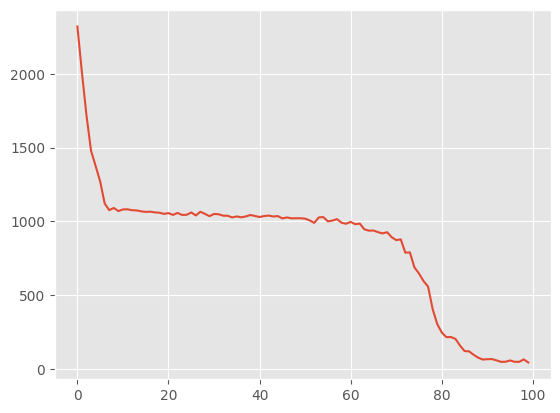

In [49]:
plt.plot(history)

In [50]:
elbo_nf, log_w_nf, x_particles_nf, ancestors_nf = vsmc_nf(y_seq_zeros, N=N, T=T, flow=flow)

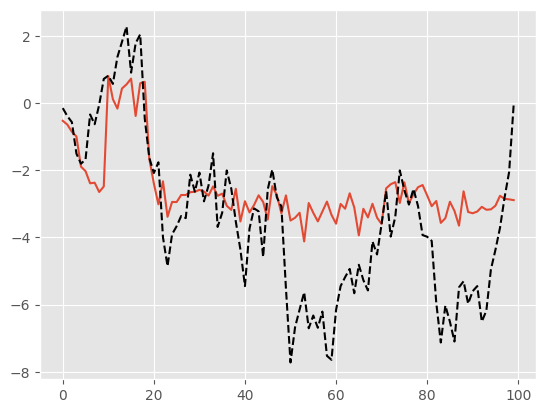

In [51]:
plt.plot(x_particles_nf.mean(axis=1)[:,0].detach().numpy())
plt.plot(X_hat, ls='--', c='black')

(0.0, 1000.0)

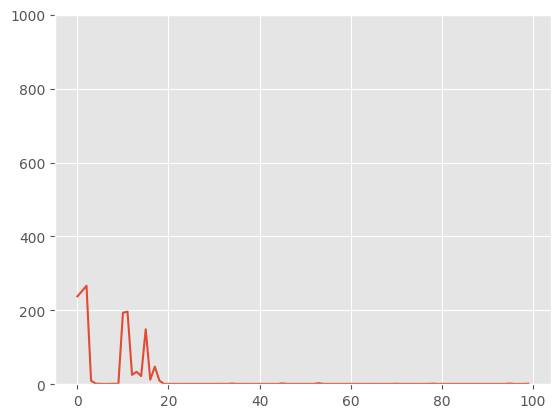

In [52]:
plt.plot(ESS(log_w_nf).detach().numpy())
plt.ylim((0,1000))


In [53]:
lr = 1e-4
n_epochs = 100
# latent_dim = 2

history = []

# flow = RealNVP(dim=latent_dim, n_layers=4, base_dist=base_dist, context_dim=context_dim)


latent_dim = 2
context_dim = latent_dim
base_dist = MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))

flow = RealNVP(dim=latent_dim, n_layers=3, base_dist=base_dist, context_dim=context_dim)


# === Training Loop ===
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    logZ, _, _, _ = vsmc_nf(y_seq_repeat, N=N, T=T, flow=flow)
    loss = -logZ
    # print(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
    optimizer.step()
    history.append(loss.item()) 
    # if epoch % 10 == 0:
    print(f"Epoch {epoch}: ELBO = {logZ.item():.4f}")

Epoch 0: ELBO = -8528.8223
Epoch 1: ELBO = -8166.2271
Epoch 2: ELBO = -7392.6729
Epoch 3: ELBO = -7061.2197
Epoch 4: ELBO = -6059.5283
Epoch 5: ELBO = -5664.2695
Epoch 6: ELBO = -4844.3506
Epoch 7: ELBO = -4211.9937
Epoch 8: ELBO = -3696.7166
Epoch 9: ELBO = -3155.6528
Epoch 10: ELBO = -2726.3518
Epoch 11: ELBO = -2402.4343
Epoch 12: ELBO = -2192.2263
Epoch 13: ELBO = -1975.7007
Epoch 14: ELBO = -1953.1017
Epoch 15: ELBO = -1967.4742
Epoch 16: ELBO = -1936.8766
Epoch 17: ELBO = -1940.2168
Epoch 18: ELBO = -1942.8997
Epoch 19: ELBO = -1946.2507
Epoch 20: ELBO = -1943.6951
Epoch 21: ELBO = -1951.1176
Epoch 22: ELBO = -1954.4678
Epoch 23: ELBO = -1954.1176
Epoch 24: ELBO = -1948.1165
Epoch 25: ELBO = -1944.9365
Epoch 26: ELBO = -1948.1443
Epoch 27: ELBO = -1946.9707
Epoch 28: ELBO = -1938.2377
Epoch 29: ELBO = -1938.3030
Epoch 30: ELBO = -1934.2629
Epoch 31: ELBO = -1932.9553
Epoch 32: ELBO = -1924.1327
Epoch 33: ELBO = -1927.9658
Epoch 34: ELBO = -1915.9739
Epoch 35: ELBO = -1895.8458
Ep

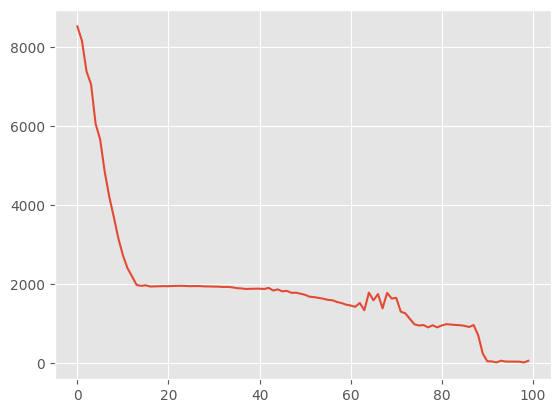

In [54]:
plt.plot(history)

In [55]:
elbo_nf_2, log_w_nf_2, x_particles_nf_2, ancestors_nf_2 = vsmc_nf(y_seq_repeat, N=N, T=T, flow=flow)

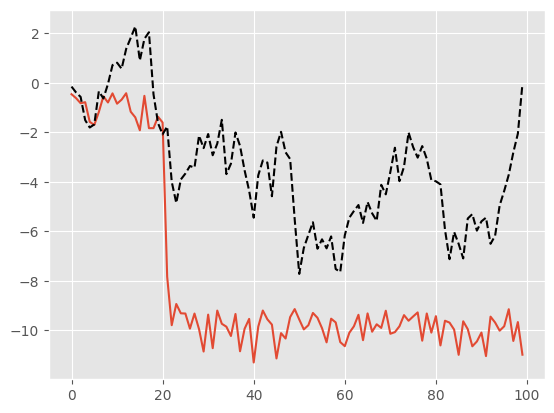

In [56]:
plt.plot(x_particles_nf_2.mean(axis=1)[:,0].detach().numpy())
plt.plot(X_hat, ls='--', c='black')

In [57]:
y_seq_test[:,1]

tensor([0.2872, 0.8062, 1.2850, 1.8150, 1.6767, 0.8782, 0.8863, 0.6341, 0.8604,
        1.6186, 1.2768, 1.6315, 1.1599, 1.2751, 1.1196, 1.5753, 2.6303, 1.3532,
        0.5824, 1.0253, 1.3031, 1.5834, 1.5707, 1.9010, 2.5736, 2.1286, 2.5932,
        2.4862, 2.6322, 2.8466, 3.4200, 3.4783, 3.1614, 2.6074, 1.9583, 1.6132,
        1.9755, 1.9857, 2.1083, 2.5753, 3.0530, 2.9376, 4.0811, 4.3126, 5.8509,
        5.5571, 4.5323, 4.5099, 4.5808, 3.7093, 4.2987, 5.1239, 6.1853, 7.0366,
        7.7376, 7.6930, 7.1111, 6.4170, 6.4102, 5.6382, 5.2327, 5.2621, 5.3943,
        4.5304, 4.6490, 4.1001, 4.3241, 4.0080, 4.5814, 4.5838, 4.8176, 5.0070,
        4.6490, 3.5221, 4.0125, 4.1238, 3.9762, 4.5508, 4.9050, 4.2195, 4.1579,
        4.6343, 4.2131, 3.5292, 3.3954, 3.5309, 4.2380, 4.2005, 4.2388, 4.3462,
        3.9954, 3.5590, 3.2408, 2.1585, 1.5350, 2.7408, 2.1945, 3.1098, 2.9160,
        2.9246])

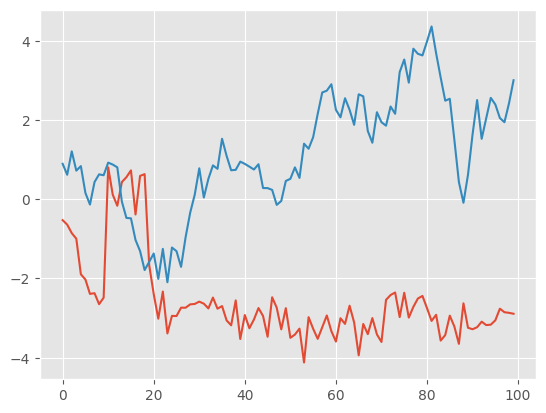

In [58]:
plt.plot(x_particles_nf.mean(axis=1)[:,0].detach().numpy())
plt.plot(y_seq_test[:,0])

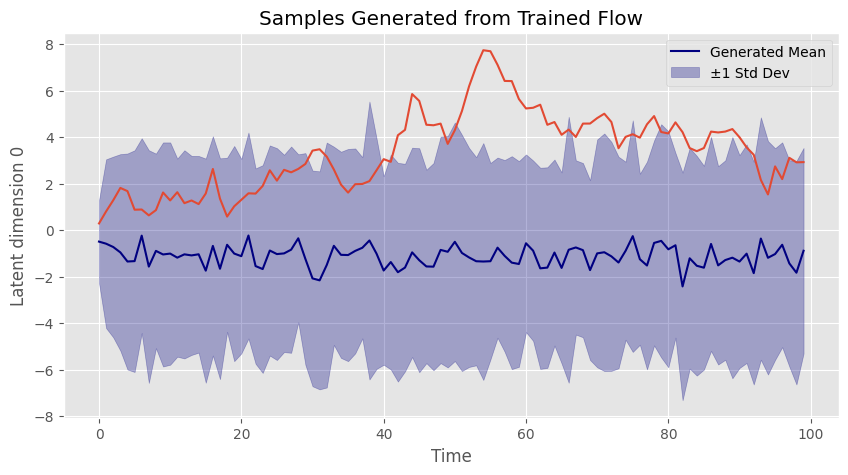

In [59]:
import torch
import matplotlib.pyplot as plt

# Assuming:
# - flow: your trained RealNVP flow model
# - latent_dim, T defined earlier
# - device set (e.g. 'cpu' or 'cuda')

flow.eval()  # set model to eval mode

# Number of samples (particles) to generate per timestep
N = 100

# If your flow is conditional on previous state (context), generate a sequence:
with torch.no_grad():
    # Start with zeros or random context for t=0
    x_prev = torch.zeros(N, latent_dim).to(next(flow.parameters()).device)

    generated_particles = []

    for t in range(T):
        # Sample base noise from standard normal
        eps = torch.randn(N, latent_dim).to(x_prev.device)
        
        # Generate samples with context = previous latent (or None for t=0)
        x_t = flow.forward(eps, context=x_prev)
        generated_particles.append(x_t.cpu())
        
        # Update context
        x_prev = x_t

    # Stack into (T, N, latent_dim)
    generated_particles = torch.stack(generated_particles)

# Now plot mean and uncertainty for latent dimension 0

mu = generated_particles[..., 1].mean(dim=1).numpy()
std = generated_particles[..., 1].std(dim=1).numpy()
time = range(T)

plt.figure(figsize=(10,5))
plt.plot(time, mu, label='Generated Mean', color='navy')
plt.plot(time, y_seq_test[:,1])
plt.fill_between(time, mu - std, mu + std, color='navy', alpha=0.3, label='±1 Std Dev')
plt.xlabel('Time')
plt.ylabel('Latent dimension 0')
plt.title('Samples Generated from Trained Flow')
plt.legend()
plt.grid(True)
plt.show()


---

# References

\[1\] T. Lacey, "Tutorial: The Kalman Filter". Accessed: Jul. 09, 2025. \[Online\]. Available: https://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf.

\[2\] C. A. Naesseth, S. W. Linderman, R. Ranganath, and D. M. Blei, "Variational Sequential Monte
Carlo." \[Online\]. Available: https://arxiv.org/abs/1705.11140.